# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import math
import numpy as np
import tensorflow_datasets as tfds
from typing import Union
from tensorflow import keras
import keras.backend as K
tf.enable_v2_behavior()
l = tf.keras.layers
builder = tfds.builder('mnist')
BATCH_SIZE = 256
learning_rate = 1e-3
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

# Data loading

In [2]:
# Load train and test splits.
def preprocess(x):
    image = tf.image.convert_image_dtype(x['image'], tf.float32)
    subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
    return image, subclass_labels

def get_flops():
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.compat.v1.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [3]:
#@test {"output": "ignore"}
# Build CNN teacher.
cnn_model = tf.keras.Sequential([l.Conv2D(input_shape=(28,28,1), filters=32, kernel_size=3, strides=1, activation='relu'),
                                l.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                                l.Conv2D(input_shape=(28,28,1), filters=64, kernel_size=3, strides=1, activation='relu'),
                                l.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
                                l.Flatten(),
                                l.Dropout(0.5),
                                l.Dense(128, activation='relu'),
                                l.Dropout(0.5),
                                l.Dense(NUM_CLASSES)])
                                

# your code start from here for stpe 2
# Build fully connected student.
fc_model = tf.keras.Sequential([l.Flatten(),
                                l.Dense(784, activation='relu'),
                                l.Dense(784, activation='relu'),
                                l.Dense(NUM_CLASSES)])


# your code start from here for step 2

# Teacher loss function

In [4]:
#@tf.function
def compute_teacher_loss(images, labels):
#   """Compute subclass knowledge distillation teacher loss for given images
#      and labels.

#   Args:
#     images: Tensor representing a batch of images.
#     labels: Tensor representing a batch of labels.

#   Returns:
#     Scalar loss Tensor.
#   """
    subclass_logits = cnn_model(images, training=True)
    # Compute cross-entropy loss for subclasses.

    # your code start from here for step 3
    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, subclass_logits))


    return cross_entropy_loss_value

# Student loss function

In [21]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64 #temperature hyperparameter

def distillation_loss(teacher_logits, student_logits, temperature = DISTILLATION_TEMPERATURE):
#     """Compute distillation loss.

#     This function computes cross entropy between softened logits and softened
#     targets. The resulting loss is scaled by the squared temperature so that
#     the gradient magnitude remains approximately constant as the temperature is
#     changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
#     a neural network."

#     Args:
#     teacher_logits: A Tensor of logits provided by the teacher.
#     student_logits: A Tensor of logits provided by the student, of the same
#       shape as `teacher_logits`.
#     temperature: Temperature to use for distillation.

#     Returns:
#     A scalar Tensor containing the distillation loss.
#     """
    # your code start from here for step 3
    soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = 1)
    
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
#     """Compute subclass knowledge distillation student loss for given images
#     and labels.

#     Args:
#     images: Tensor representing a batch of images.
#     labels: Tensor representing a batch of labels.

#     Returns:
#     Scalar loss Tensor.
#     """
    student_subclass_logits = fc_model(images, training=True)

    # Compute subclass distillation loss between student subclass logits and
    # softened teacher subclass targets probabilities.

    # your code start from here for step 3

    teacher_subclass_logits = cnn_model(images, training=False)
    distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

    # Compute cross-entropy loss with hard targets.

    # your code start from here for step 3

    cross_entropy_loss_value = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))
    
    total_loss = cross_entropy_loss_value * ALPHA + (1 - ALPHA) * distillation_loss_value

    return total_loss

# Train and evaluation

In [24]:
#@tf.function
def tf_reduceat(data, at_array, axis=-1):
    split_data = tf.split(data, at_array, axis=axis)
    return tf.stack([tf.reduce_sum(i, axis=axis) for i in split_data], axis=axis)
    
def compute_num_correct(model, images, labels):
#     """Compute number of correctly classified images in a batch.

#     Args:
#     model: Instance of tf.keras.Model.
#     images: Tensor representing a batch of images.
#     labels: Tensor representing a batch of labels.

#     Returns:
#     Number of correctly classified images.
#     """
    class_logits = model(images, training=False)
    if class_logits.shape[1] != NUM_CLASSES:
        class_logits = tf_reduceat(class_logits, [2, 2, 1, 1, 1, 1, 2, 2, 1, 2])
        
    return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, learning_rate):
#     """Perform training and evaluation for a given model.

#     Args:
#     model: Instance of tf.keras.Model.
#     compute_loss_fn: A function that computes the training loss given the
#       images, and labels.
#     """

    # your code start from here for step 4
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(1, NUM_EPOCHS + 1):
        # Run training.
        print('Epoch {}: '.format(epoch), end='')
        for images, labels in mnist_train:
            with tf.GradientTape() as tape:
                # your code start from here for step 4

                loss_value = compute_loss_fn(images, labels)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))


    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
        # your code start from here for step 4
        num_correct += compute_num_correct(model, images, labels)[0].numpy()
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    return num_correct / num_total * 100


# Training models

In [23]:
# your code start from here for step 5 
print('Start training teacher model')
test_acc_cnn = train_and_evaluate(cnn_model, compute_teacher_loss,learning_rate)
print('Test accuracy for teacher model is {}'.format(test_acc_cnn))
print('-------------------------------------')
print('Start training student model')
print(DISTILLATION_TEMPERATURE)
test_acc_fc = train_and_evaluate(fc_model, compute_student_loss, learning_rate)
print('Test accuracy for student model is {}'.format(test_acc_fc))

Start training teacher model
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 99.31%
Test accuracy for teacher model is 99.31
-------------------------------------
Start training student model
64
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.92%
Test accuracy for student model is 98.92


# Test accuracy vs. tempreture curve

In [ ]:
temperature_set = [1,2,4,16,32,64]
test_acc_set = []
for temp in temperature_set:
    fc_model = tf.keras.Sequential([l.Flatten(),
                                l.Dense(784, activation='relu'),
                                l.Dense(784, activation='relu'),
                                l.Dense(NUM_CLASSES)])
    DISTILLATION_TEMPERATURE = temp
    test_acc_i = train_and_evaluate(fc_model, compute_student_loss, learning_rate)
    test_acc_set.append(test_acc_i)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.18%
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.40%
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.65%
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.71%
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.77%
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.87%


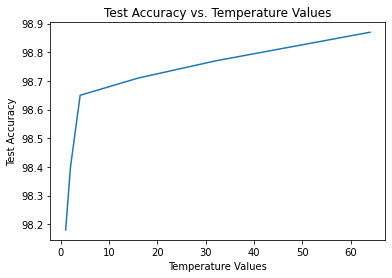

In [ ]:
import matplotlib.pyplot as plt

plt.plot(temperature_set, test_acc_set)

plt.xlabel('Temperature Values')
plt.ylabel('Test Accuracy')    
plt.title('Test Accuracy vs. Temperature Values')
plt.show()

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([l.Flatten(),
                                l.Dense(784, activation='relu'),
                                l.Dense(784, activation='relu'),
                                l.Dense(NUM_CLASSES)])

# your code start from here for step 7



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
#     """Compute plain loss for given images and labels.

#     For fair comparison and convenience, this function also performs a
#     LogSumExp over subclasses, but does not perform subclass distillation.

#     Args:
#     images: Tensor representing a batch of images.
#     labels: Tensor representing a batch of labels.

#     Returns:
#     Scalar loss Tensor.
#     """
    # your code start from here for step 7

    student_subclass_logits = fc_model_no_distillation(images, training=True)
    cross_entropy_loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

    return cross_entropy_loss

DISTILLATION_TEMPERATURE = 64
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss, learning_rate)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 98.19%


98.19

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras_flops
from keras_flops import get_flops
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print('cnn model summary')
cnn_model.summary()
print('fc model summary')
fc_model.summary()
flops = get_flops(cnn_model, batch_size=1)
print('FLOPs for cnn model is {}'.format(flops))
flops = get_flops(fc_model, batch_size=1)
print('FLOPs for fc model is {}'.format(flops))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cnn model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7744)              0         
     

# Implementing the state-of-the-art KD algorithm

In [25]:
DISTILLATION_TEMPERATURE = 16
learning_rate = 1e-3
# your code start from here for step 12
cnn_model_SbD = tf.keras.Sequential([l.Conv2D(input_shape=(28,28,1), filters=32, kernel_size=3, strides=1, activation='relu'),
                                l.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
                                l.Conv2D(input_shape=(28,28,1), filters=64, kernel_size=3, strides=1, activation='relu'),
                                l.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
                                l.Flatten(),
                                l.Dropout(0.5),
                                l.Dense(128, activation='relu'),
                                l.Dropout(0.5),
                                l.Dense(NUM_CLASSES+5)])
                                

# your code start from here for stpe 2
# Build fully connected student.
fc_model_SbD = tf.keras.Sequential([l.Flatten(),
                                l.Dense(784, activation='relu'),
                                l.Dense(784, activation='relu'),
                                l.Dense(NUM_CLASSES+5)])

def compute_teacher_loss_SbD(images, labels):     
        
    subclass_logits_Z = cnn_model_SbD(images, training=True)
    subclass_logits_P = tf.nn.softmax(subclass_logits_Z)
    subclass_logits_P_sumed = tf_reduceat(subclass_logits_P, [2, 2, 1, 1, 1, 1, 2, 2, 1, 2])
    
    cee = tf.keras.losses.CategoricalCrossentropy()
    cross_entropy_loss_value = cee(labels, subclass_logits_P_sumed)
    temperature =50
    BETA = 0.4
    
    def Auxiliary_loss(subclass_logits_Z, temperature):
        mean = tf.math.reduce_mean(subclass_logits_Z, axis = 1)
        var = tf.math.reduce_variance(subclass_logits_Z, axis = 1)
        normalizer = tf.keras.layers.Normalization(axis=0, mean=mean, variance=var)
        subclass_logits_Z = normalizer(subclass_logits_Z)

        subclass_logits_Z_transposed = tf.transpose(subclass_logits_Z)
        logics_vectors = tf.matmul(subclass_logits_Z, subclass_logits_Z_transposed)
        logics_vectors /= temperature
        exp_values = tf.math.exp(logics_vectors)
        log_term = tf.reduce_sum(exp_values, 1)
        log_results = tf.math.log(log_term)
        log_results -= (1/temperature)
        log_results -= math.log(BATCH_SIZE)
        auxiliary_loss = tf.reduce_mean(log_results)
        return auxiliary_loss
    
    auxiliary_loss = Auxiliary_loss(subclass_logits_Z, temperature)
    teacher_loss = cross_entropy_loss_value + BETA * auxiliary_loss
    return teacher_loss

def distillation_loss_SbD(teacher_logits, student_logits, temperature = DISTILLATION_TEMPERATURE):

    soft_targets = tf.nn.softmax(teacher_logits/temperature, axis = 1)
    
    return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss_SbD(images, labels):

    student_subclass_logits_Z = fc_model_SbD(images, training=True)

    teacher_subclass_logits_Z = cnn_model_SbD(images, training=False)
    
    student_subclass_logits_P = tf.nn.softmax(student_subclass_logits_Z)
    student_subclass_logits_P_sumed = tf_reduceat(student_subclass_logits_P, [2, 2, 1, 1, 1, 1, 2, 2, 1, 2])
    
    cee = tf.keras.losses.CategoricalCrossentropy()
    cross_entropy_loss_value = cee(labels, student_subclass_logits_P_sumed)
    
    distillation_loss_value = distillation_loss_SbD(teacher_subclass_logits_Z, student_subclass_logits_Z, DISTILLATION_TEMPERATURE)

    student_loss = cross_entropy_loss_value * ALPHA + (1 - ALPHA) * distillation_loss_value

    return student_loss

# your code start from here for step 5 
print('Start training teacher model using subclass distallation')
test_acc_cnn = train_and_evaluate(cnn_model_SbD, compute_teacher_loss_SbD, learning_rate)
print('Test accuracy for teacher model is {}'.format(test_acc_cnn))
print('-------------------------------------')
print('Start training student model using subclass distallation')
print(DISTILLATION_TEMPERATURE)
test_acc_fc = train_and_evaluate(fc_model_SbD, compute_student_loss_SbD, learning_rate)
print('Test accuracy for student model is {}'.format(test_acc_fc))

Start training teacher model using subclass distallation
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 99.49%
Test accuracy for teacher model is 99.49000000000001
-------------------------------------
Start training student model using subclass distallation
16
Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Class_accuracy: 99.12%
Test accuracy for student model is 99.12


# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
        
    
